# ECG data

In this tutorial you will work with ECG data. We suggest loading ECG data from PhysioNet database of short single lead ECG recording. Follow this [link](https://physionet.org/challenge/2017/) and find archive "training2017.zip" or use [direct](https://physionet.org/challenge/2017/training2017.zip) link. However, if you do not want to do it now, you can find several ECGs from that database in folder cardio/tests/data (folder is icluded in CardIO repository).

The PhysioNet archive contains 8.528 ECGs in [wfdb](https://www.physionet.org/physiotools/wpg/wpg_35.htm) format. Each ECG has a unique index ranging from "A00001" to "A08528". According to wbdf format ECG record has 2 files with ```.hea``` and ```.mat``` extensions. File ```.hea``` contains signal, while ```.mat``` contains meta information about the signal (e.g. sample rate). 

Since the acrhive was prepared for arrhythmia classification it also contains file REFERENCE.csv, where each ECG index is labeled with one of four classes:
* Normal rhythm
* AF
* Other rhythm
* Noise

Read [here](https://physionet.org/challenge/2017/) more about PhysioNet database.

# Create a dataset of ecg

In Notebook 1 we explain how to create a [dataset](https://github.com/analysiscenter/dataset/) of ECGs and give very basic examples how to use dataset. 

## Index ecg

Working with ECG begins with ```FilesIndex```. ```FilesIndex``` contains index and location of each ECG record we want to process. 

Let all ECGs be stored in wfdb format in folder with path 'data/ECG'. Let's create a new ```FilesIndex``` with all ECGs from this folder.

In [1]:
import sys
sys.path.append("..")

import cardio.dataset as ds
index = ds.FilesIndex(path="../cardio/tests/data/*.hea", no_ext=True, sort=True)

Using TensorFlow backend.


Now each ECG is indexed with its filename. Indices are stored in ```index.indices```:

In [2]:
print(index.indices)

['A00001' 'A00002' 'A00004' 'A00005' 'A00008' 'A00013']


## Init dataset

We have ```index``` that knows which ECGs we want to process and a class [EcgBatch](https://github.com/analysiscenter/cardio/blob/master/doc/batch.md) that knows how to process ECGs. Combining it together we obtain a dataset:

In [3]:
from cardio import EcgBatch
eds = ds.Dataset(index, batch_class=EcgBatch)

## Start using dataset

Let's generate a first batch of size 1000:

In [4]:
batch = eds.next_batch(batch_size=100)

Up to now ```batch``` does not contain any data, only indices and paths to ECGs. 

## Apply action

Any preprocess begins with loading of data. Therefore, the first example is action ```load```. Note that paths to ECGs are already in batch, so simply inticate data format and component we want to load. We load components ```signal```  and  ```meta```:

In [5]:
batch_with_data = batch.load(fmt="wfdb", components=["signal", "meta"])

Now ```batch_with_data``` contatains 1000 loaded ECGs. Any ECG record can be accessed by its index, e.g. ```batch['A00010']```. ECG signal and meta can be accessed as ```batch['A00010'].signal``` and ```batch['A00010'].meta``` correspondingly.

Let's plot signal from ECG with index```'A00010'```:

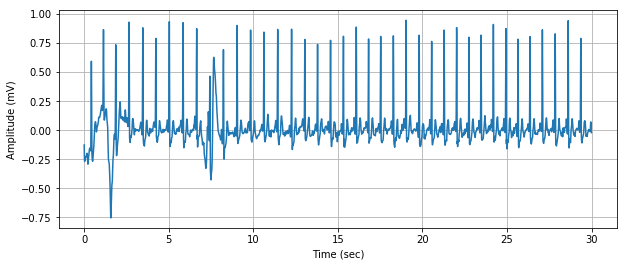

In [6]:
batch_with_data.show_ecg('A00001')

Any other action can be applied to ```batch_with_data``` in the same way as ```load```, e.g. action ```flip_signals```. It flips signals whose R-peaks are directed downwards. Nore that ```flip_signals``` modifies batch inplace, so we create copy of the batch:

In [7]:
original_batch = batch_with_data.deepcopy()

And then apply ```flip_signal``` action:

In [8]:
batch_with_data.flip_signals()

Now we can compare results:

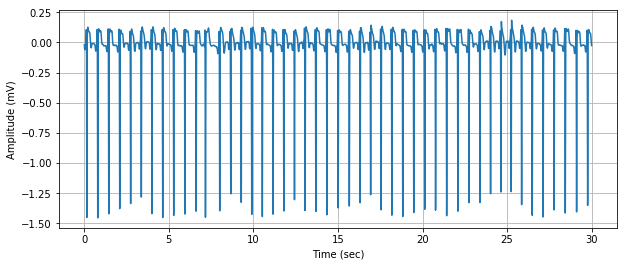

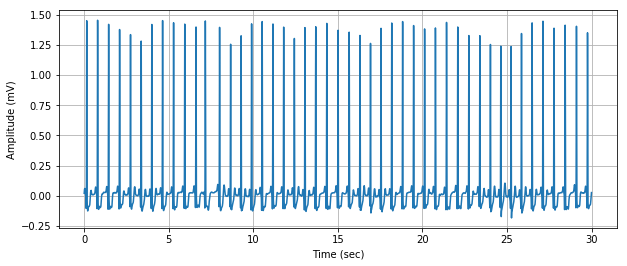

In [9]:
original_batch.show_ecg('A00013')

batch_with_data.show_ecg('A00013')

Summarizing, in Notebook 1 we learned:
* how to get ECG data
* how to create datasets
* how to apply actions.

In the next [Notebook 2](https://github.com/analysiscenter/cardio/blob/hmm_model_update/tutorials/II.Pipelines.ipynb) we will combine actions in pipeline.